In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from keras.datasets import mnist

import warnings
warnings.filterwarnings("ignore")

## <span style='color:rgb(37, 150, 190)'> 1 | Pengaturan Config </span><a class="anchor" id="dConfig"></a>
<hr>

In [29]:
import sys
sys.path.append('../configs/')
from config import load_config

In [50]:
config = load_config(path='../configs/config.yaml')

## <span style='color:rgb(37, 150, 190)'> 2 | Data Overview </span><a class="anchor" id="dOverview"></a>
<hr>
The __MNIST dataset__ terdiri atas <code>60.000</code> data latih dan <code>10.000</code> data tes berupa gambar atas angka tulisan tangan dari digit nol sampai dengan sembilan (ada 10 jenis kelas digit). Data gambar berupa <i>grayscaled pixel value</i> yang direpresentasikan sebagai matriks dengan dimensi <code>28×28</code>. 

### 2.1 | Dimension of MNIST train and test data <a class="anchor" id="dTrainTest"></a>

In [47]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

print("X_train shape", X_train_mnist.shape)
print("y_train shape", y_train_mnist.shape)
print("X_test shape", X_test_mnist.shape)
print("y_test shape", y_test_mnist.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


### 2.2 | Splitting data into training, validation, and test dataset<a class="anchor" id="splitData"></a>

Data training dan test yang berasal dari <code>mnist.load_data()</code> berupa array, kedua data ini akan digabungkan terlebih dulu kemudian displit.
<ol>
    <li><b>Training dataset</b> akan digunakan untuk melakukan proses fit atas model</li>
    <li><b>Validation dataset</b> yang akan digunakan untuk evaluasi atas model</li>
    <li><b>Test dataset</b> yang akan digunakan untuk model testing</li>
 </ol>

Proses ini akan menggunakan <code>train_test_split()</code> berdasarkan rasio yang sudah ditentukan (training 70%, validation 10%, dan training 20%). 

In [31]:
# Menggabungkan X dan y atas train dan test dataset
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [52]:
# Menyimpan dataset gabungan sebagai data raw dalam format pickle
def dump_to_pickle(path, obj_to_dump):
    with open(path, 'wb') as f:
        pickle.dump(obj_to_dump, f)

In [54]:
dump_to_pickle(config['raw_dataset_dir'][0], X)
dump_to_pickle(config['raw_dataset_dir'][1], y)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1-config['train_ratio'])
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((config['test_ratio']/(config['validation_ratio']+config['test_ratio']))))

### 2.3 | Dimension of training, validation, and test data<a class="anchor" id="dTrainValTest"></a>
[Back to Table of Contents](#bcImp)

In [60]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_validation shape', X_val.shape)
print('y_validation shape', y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (48999, 28, 28)
y_train shape (48999,)
X_validation shape (14000, 28, 28)
y_validation shape (14000,)
X_test shape (7001, 28, 28)
y_test shape (7001,)


## <span style='color:rgb(37, 150, 190)'> 3 | Data Exploration </span><a class="anchor" id="dOverview"></a>
<hr>
Untuk proses selanjutnya, model yang akan digunakan membutuhkan input data berupa array sehingga perlu dipastikan semua data memiliki format objek array.

In [59]:
print('X_train:', type(X_train))
print('y_train:', type(y_train))
print('X_validation:', type(X_val))
print('y_validation:', type(y_val))
print("X_test:", type(X_test))
print("y_test:", type(y_test))

X_train: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
X_validation: <class 'numpy.ndarray'>
y_validation: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>


### 3.1 | Visualise digits <a class ="anchor" id="visualizeData"></a>
[Back to Table of Contents](#bcImp)

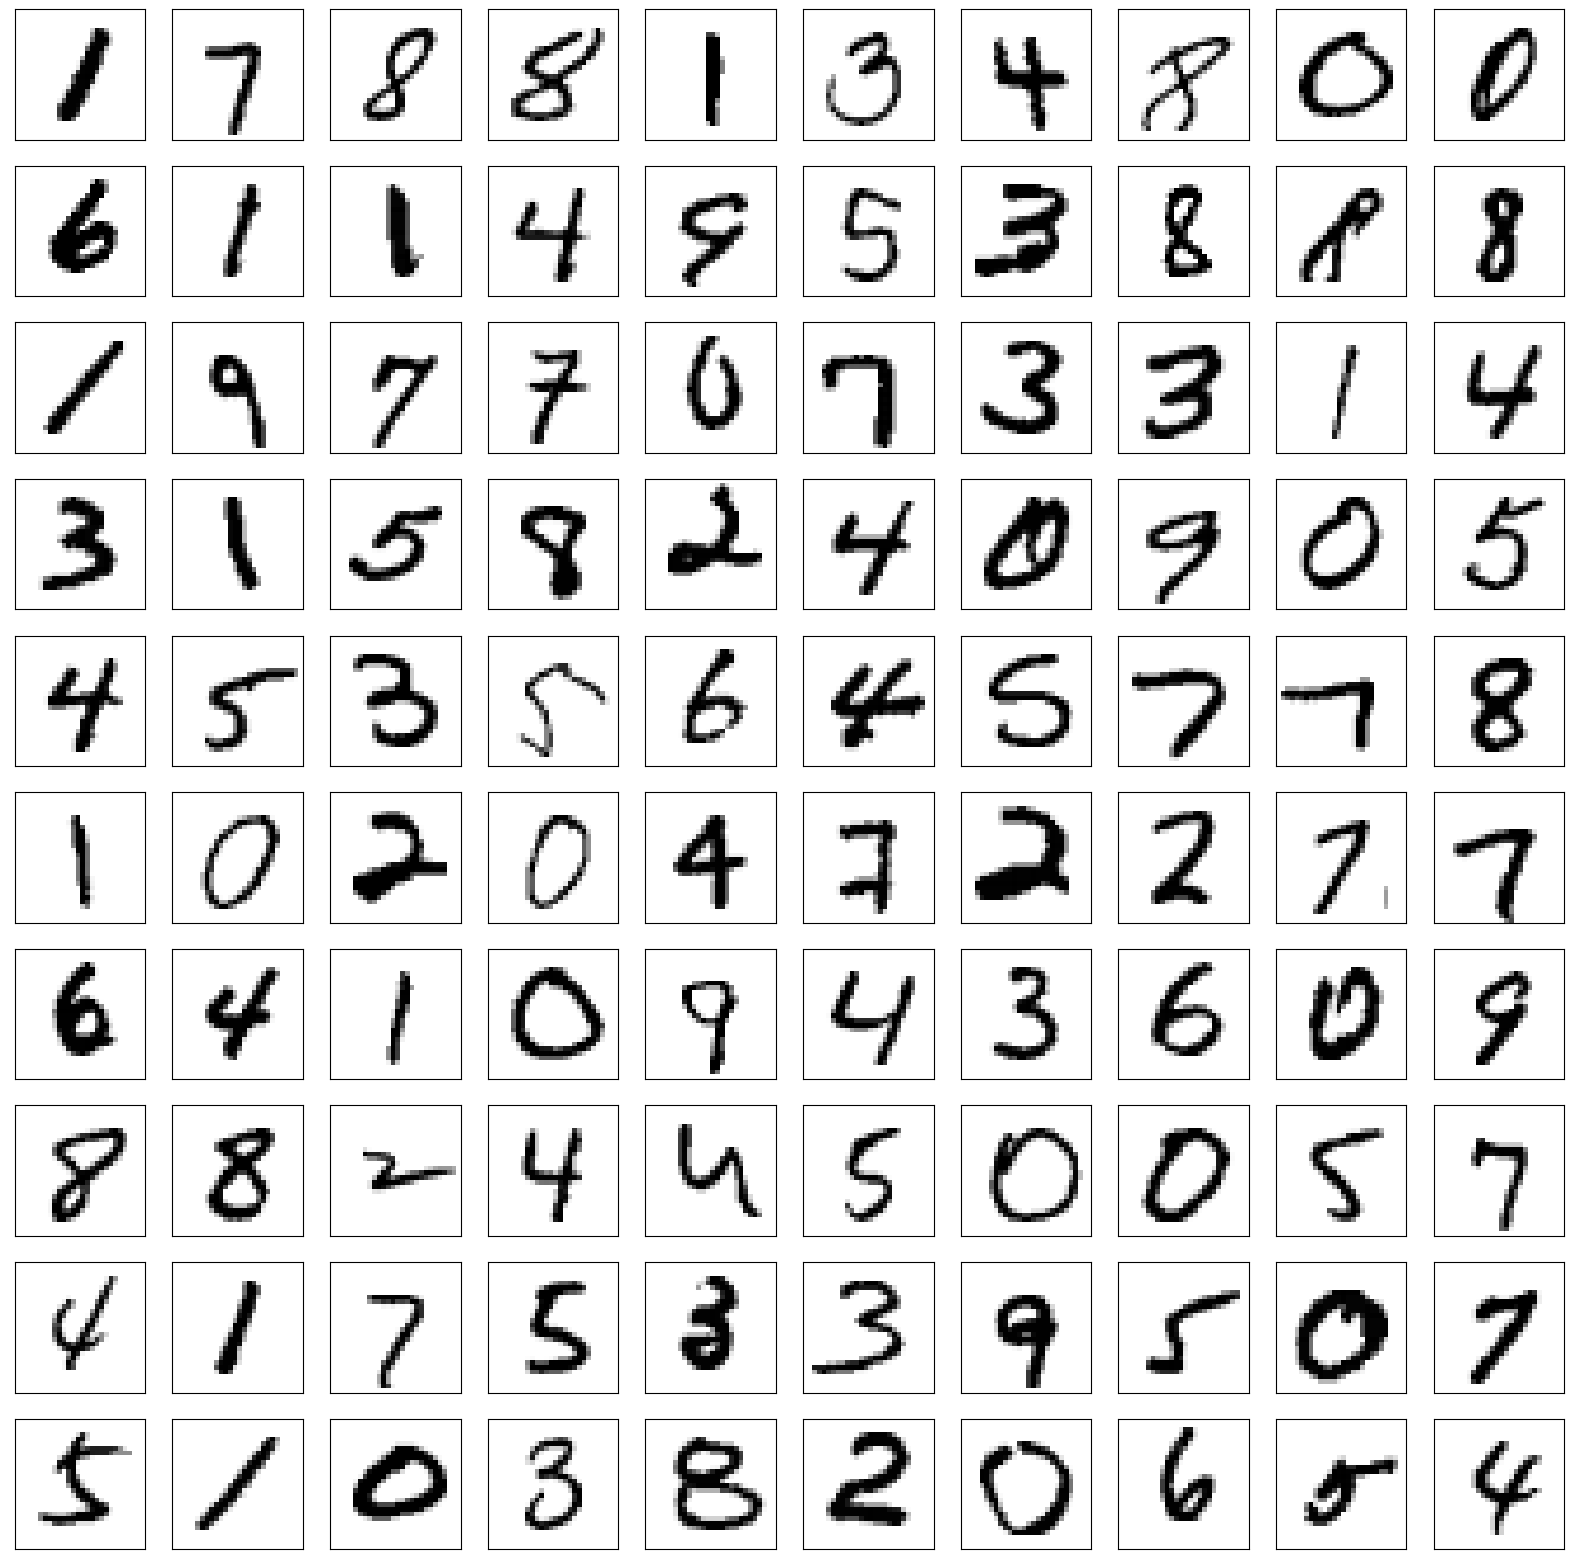

In [77]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

### 3.2 | Reshaping train, test, and validation data <a class ="anchor" id = "reshapeData"></a>
[Back to Table of Contents](#bcImp)

Pada <i>convolution layers</i>, data input perlu dilakukan <i>reshape</i> dan ditambahkan <i>color channel</i>. Dari ekspolari sebelumnya telah diketahui bahawa setiap data memiliki dimensi 28 x 28 yang dapat diartikan bahwa data tersebut berupa matriks <i>color values</i> berukuran 28 x 28 yang merepresentasikan piksel dengan nilai antara 0 sampai dengan 255. Dimensi data akan diubah menjadi (28, 28, 1) dimana nilai 1 merupakan <i>color channel</i>, karena data gambar yang digunakan berupa <i>grayscale</i> maka hanya akan memiliki 1 <i>color channel</i>  